# Fit mock data to cosmology
Now that the data has been looked at a little, time to actually see how well it lines up with mock data from LIGO...

This file is more or less just running mock LIGO data through the same analysis as the real LIGO data in [this GitHub repository](https://github.com/tannermurphey/LIGO-O3b-Analysis/). The main difference is just how the data is loaded since it is stored differently.

In [1]:
import h5py
import pandas as pd
import glob
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import aesara.tensor as at
import aesara.tensor.extra_ops as ate
import arviz as az
from astropy import units as u
from astropy import constants as con
from astropy.cosmology import Planck18
from scipy.integrate import quad
from tqdm import tqdm
import warnings
from scipy import integrate
import seaborn as sns

sns.set_context('notebook')
sns.set_palette('colorblind')

%matplotlib inline

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## First things first...
Lets just redo the final cell from `check-data.ipynb` just to keep an idea of what we're dealing with here...

dl (3643, 1000) [6.59349306 8.86409326 9.76509411 ... 6.34050207 6.05096004 7.48942135]
logwt (3643, 1000) [-2.40568924 -0.81689137 -1.84977946 ... -1.45239887 -0.10665112
 -1.24730617]
m1_detector (3643, 1000) [ 94.28824527  88.31122969 103.52489157 ...  43.06554259  78.98666661
  34.08843618]
q (3643, 1000) [0.48612534 0.67861325 0.68782264 ... 0.63571671 0.18529976 0.81651512]
eta_obs (3643,) [0.17778629 0.09639146 0.19186613 ... 0.19086518 0.1182414  0.14672015]
log_dl_obs (3643,) [2.17432848 1.35421172 2.56688951 ... 1.83623987 2.09124712 1.82413581]
log_mc_obs (3643,) [4.28150646 3.00204991 4.33963383 ... 2.81016791 3.90475574 3.30574167]
sigma_eta (3643,) [0.15271375 0.10098905 0.08593887 ... 0.06459675 0.10837015 0.19688065]
sigma_log_dl (3643,) [0.22376062 0.09773493 0.0643292  ... 0.11470738 0.15828442 0.16677532]
sigma_log_mc (3643,) [0.19221485 0.05488187 0.02299871 ... 0.07594466 0.0514777  0.10679807]
snr_obs (3643,) [10.428266   14.39574566 22.13476341 ... 16.2941247   9

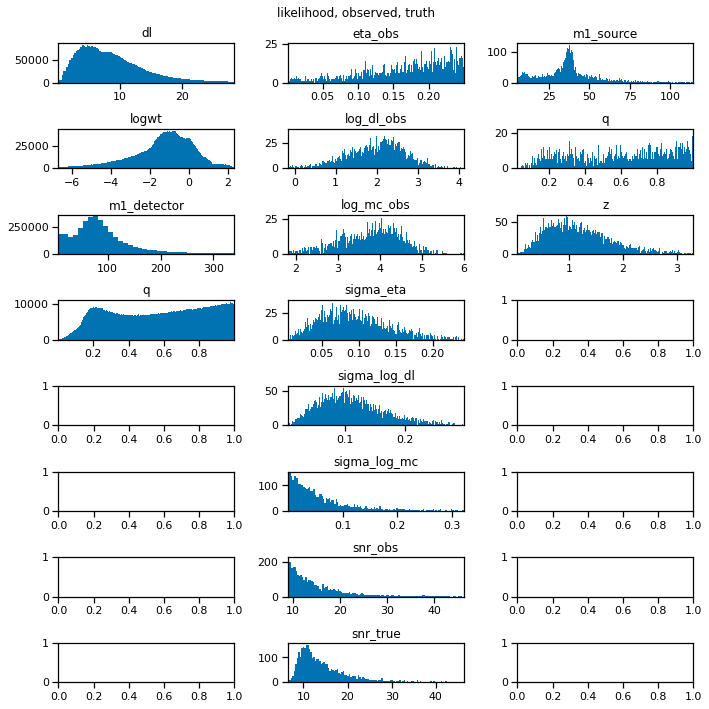

In [2]:
f = "observations.h5"
with h5py.File(f, 'r') as hf:
    keys = list(hf.keys())
    max_len = max([len(list(hf[key])) for key in keys])
    
    fig, axs = subplots(max_len, len(keys), figsize=(10, 10)) #yes I know it's only 3 keys, this keeps it general
    
    for ind_y, key in enumerate(keys):
        params = list(hf[key])
        for ind_x, param in enumerate(params):
            data = array(hf[key][param]).flatten()
#             data = array([np.random.choice(i) for i in hf[key][param]])
            print(param, hf[key][param].shape, data)
            axs[ind_x][ind_y].hist(data, bins=500)
            axs[ind_x][ind_y].set_title(param)
            
            mu = mean(data)
            sigma =std(data)
            up = min(max(data), mu+3*sigma) #upper bound of plot
            low = max(min(data), mu-3*sigma)
            
            axs[ind_x][ind_y].set_xlim(low, up)
    
#     fig.suptitle(sum([str(k) for k in keys]))
    fig.suptitle("likelihood, observed, truth") #This breaks the earlier reason, but the line above didn't work
    fig.tight_layout()

## Now lets try fitting some cosmology

A lot of this will be stuff pulled from the LIGO data fittings because there's no need to reinvent the wheel. The main difference will be that, instead of pulling one sample from each event, all events correspond to rows in this data

Now let's start with the functions for the MCMC:

In [3]:
### Functions for implementing MCMC using PyMC4

def at_interp(x, xs, ys):
    '''Custom linear interpolator'''
    x  = at.as_tensor(x)
    xs = at.as_tensor(xs)
    ys = at.as_tensor(ys)

    n = xs.shape[0]
    
    ind = ate.searchsorted(xs, x)
    ind = at.where(ind >= n, n-1, ind)
    ind = at.where(ind < 0, 0, ind)
    r = (x - xs[ind-1])/(xs[ind]-xs[ind-1]) 
    return r*ys[ind] + (1-r)*ys[ind-1]

def Ez(z, Om, w):
    opz = 1 + z
    return at.sqrt(Om*opz*opz*opz + (1-Om)*opz**(3*(1+w)))

def dCs(zs, Om, w):
    dz = zs[1:] - zs[:-1]
    fz = 1/Ez(zs, Om, w)
    I = 0.5*dz*(fz[:-1] + fz[1:]) #trapazoidally integrating
    return at.concatenate([at.as_tensor([0.0]), at.cumsum(I)])

def dLs(zs, dCs):
    return dCs*(1+zs)

def make_model(ms_obs, sigma_ms_obs, dls, zmax=100):
    zinterp = expm1(linspace(log(1), log(1+zmax), 1024))

    with pm.Model() as model:
        w = pm.Normal('w', mu=-1, sigma=0.25) 

        Om = pm.Bound('Om', pm.Normal.dist(mu=0.3, sigma=0.15), lower=0, upper=1)

        h = pm.Bound('h', pm.Lognormal.dist(mu=log(0.7), sigma=0.2), lower=0.35, upper=1.4)
#         h = pm.Lognormal('h', mu=log(0.7), sigma=0.2)
        Ode = pm.Deterministic('Ode', 1-Om)
        om = pm.Deterministic('om', Om*h*h)
        ode = pm.Deterministic('ode', Ode*h*h)

        dH= pm.Deterministic('dH', 2.99792/h)
        m0 = pm.Lognormal('m0', mu=log(35), sigma=0.5)

        dCinterp = dH*dCs(zinterp, Om, w)
        dLinterp = dLs(zinterp, dCinterp)
        
        zs = pm.Deterministic('zs', at_interp(dls, dLinterp, zinterp))

        pm.Normal('m_likelihood', mu=m0*(1+zs), sigma=sigma_ms_obs, observed=ms_obs)
    return model

In [4]:
def find_argmax_gridsearch(xs, fxs):
    imax = np.argmax(fxs)

    if imax == 0 or imax == len(xs)-1:
        warnings.warn('max occurs at grid boundary')
        return xs[imax]

    x0, x1, x2 = xs[imax-1], xs[imax], xs[imax+1]
    f0, f1, f2 = fxs[imax-1], fxs[imax], fxs[imax+1]

    dx01 = x0-x1
    dx12 = x1-x2
    dx20 = x2-x0

    sx01 = x0+x1
    sx12 = x1+x2
    sx20 = x2+x0

    xmax = (f2*dx01*sx01 + f0*dx12*sx12 + f1*dx20*sx20)/(2*(f2*dx01 + f0*dx12 + f1*dx20))

    return xmax


In [5]:
### Get m1_det and luminosity distances from data
f = "observations.h5"
n_mc = 128
m_cut = 25
n_dl = 10

with h5py.File(f, 'r') as hf:
    dl_max = np.max(hf['likelihood']['dl'])
    m_max = np.max(hf['likelihood']['m1_detector'])

    m1_det = np.array(hf['likelihood']['m1_detector'])
    dl = np.array(hf['likelihood']['dl'])

nevents, nsamples = dl.shape

m_grid = np.exp(np.linspace(np.log(m_cut), np.log(m_max), 1024))
dl_cent = np.quantile(dl.flatten(), np.linspace(0.05, 0.95, n_dl))

DLG, MG = np.meshgrid(dl_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dl))

In [6]:
event_index_arr = np.arange(nevents)

for run in tqdm(range(n_mc)):
    sample_index_arr = np.random.randint(0, nsamples,  nevents)

    m = m1_det[event_index_arr, sample_index_arr]
    d = dl[event_index_arr, sample_index_arr]
    
    ### Sort out BH around 35M_sun mass bump
    mask = m > m_cut

    masked_m = m[mask]
    masked_d = d[mask]


    ### Set up KDE and pull out ridge

    arr = np.array([masked_d, masked_m])
    kde = gaussian_kde(arr)

    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)

    for i in range(n_dl):
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:13<00:00,  1.75it/s]


In [7]:
dl_cent, np.mean(mpeak_samples, axis=0), np.std(mpeak_samples, axis=0)

(array([ 2.10449566,  3.54320088,  4.70180308,  5.85015432,  7.08645943,
         8.45526809,  9.92637987, 11.7886639 , 14.42630195, 20.61211377]),
 array([ 45.38745577,  53.82044494,  60.50515435,  66.94189554,
         73.55677827,  80.4600248 ,  87.51352337,  96.3840019 ,
        108.72685946, 134.25662112]),
 array([0.59609762, 0.49271053, 0.44582566, 0.44890254, 0.49273278,
        0.51869446, 0.55519215, 0.71356213, 0.985465  , 1.9962143 ]))

Text(0, 0.5, '$m_\\mathrm{peak} / M_\\odot$')

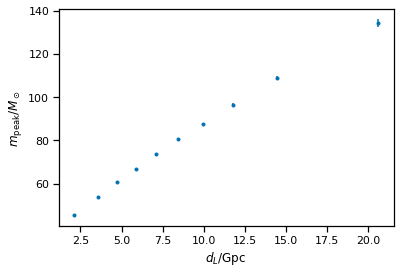

In [8]:
plt.errorbar(dl_cent, np.mean(mpeak_samples, axis=0), yerr=np.std(mpeak_samples, axis=0), fmt='.')
plt.xlabel(r'$d_L / \mathrm{Gpc}$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/home/tanner/.local/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
/home/tanner/.local/lib/python3.10/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6585, but should be close to 0.8. Try to increase the number of tuning steps.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


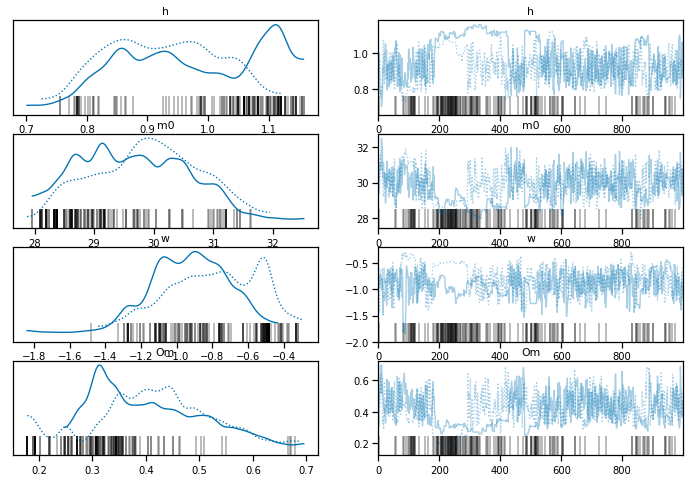

In [9]:
mu_m = np.mean(mpeak_samples, axis=0)
sigma_m = np.std(mpeak_samples, axis=0)

with make_model(ms_obs=mu_m, sigma_ms_obs=sigma_m, dls=dl_cent, zmax=10) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'])
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

Text(0, 0.5, '$m_\\mathrm{peak} / M_\\odot$')

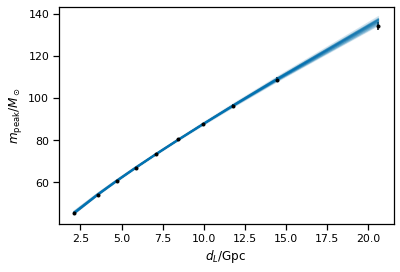

In [10]:
plt.errorbar(dl_cent, np.mean(mpeak_samples, axis=0), yerr=np.std(mpeak_samples, axis=0), fmt='.', color='k')
for _ in range(100):
    c = np.random.choice(trace.posterior.chain)
    d = np.random.choice(trace.posterior.draw)
    plt.plot(dl_cent, trace.posterior.m_peak.sel(chain=c, draw=d), color=sns.color_palette()[0], alpha=0.05)
plt.xlabel(r'$d_L / \mathrm{Gpc}$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')

array([[<AxesSubplot:ylabel='Om'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='w'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='h', ylabel='m0'>, <AxesSubplot:xlabel='Om'>,
        <AxesSubplot:xlabel='w'>]], dtype=object)

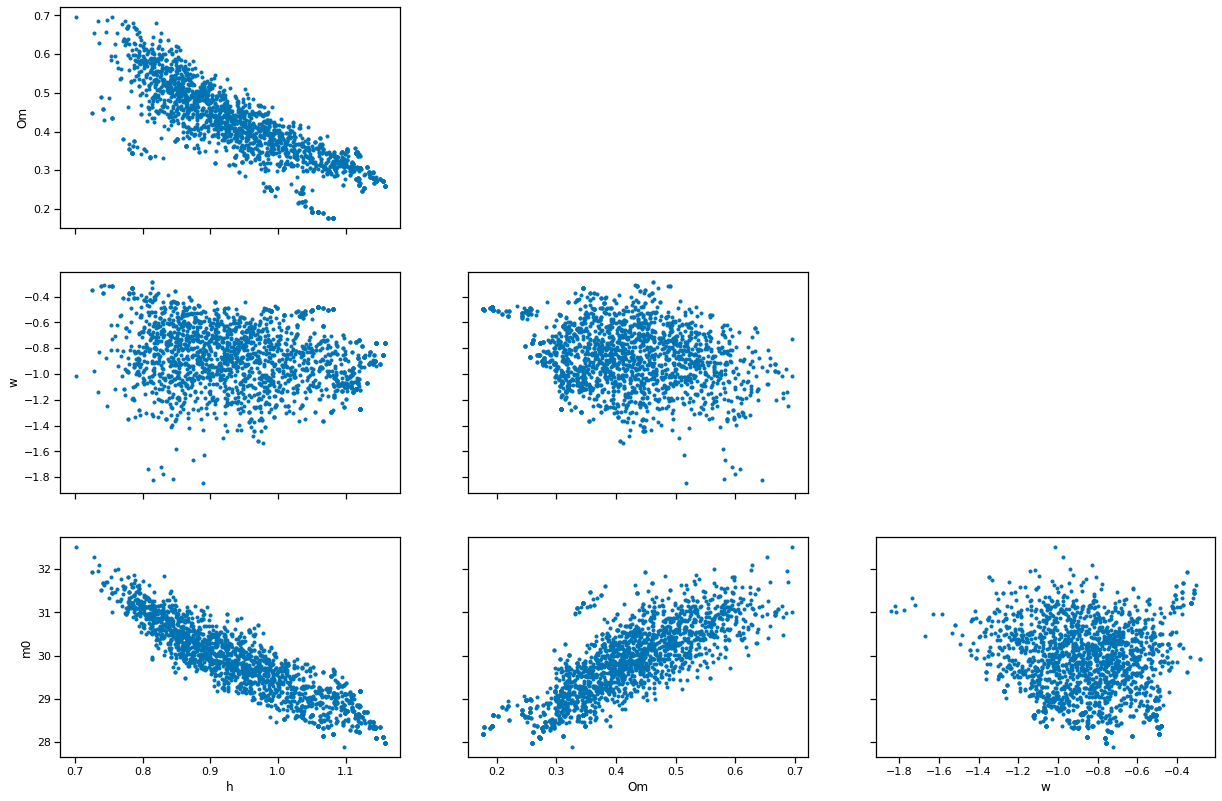

In [11]:
az.plot_pair(trace, var_names=['h', 'Om', 'w', 'm0'])

### That's diverging way too much, which explains the weird values ($h=0.9$, for example). Let's run some diagnostics

First, let's overlay the Plank+2018 values over the mock data results for $h(z)$. For an analytic comparison, we'll just throw the values from Planck+2018 into an astropy `LambdaCDM` and use the built in `H(z)` method. The steps to get the corresponding line from the data are:
1. $z=\frac{m_{det}}{M_0}-1$
2. Convert z to v using the `equivalencies` argument inside the astropy `units.to()`
3. $H(z) = \frac{v(z)}{d_L}$

This is apparently very much not the correct way to do things, needs to be nuked and redone completely

In [12]:
cosmo = Planck18 # Planck+2018 cosmology
z_range = np.linspace(0, 3, 100)

m0 = 35 #M_sun

In [14]:
def H(z, Ode, Om):
    epsilon = lambda x: (Om*(1+x)**3 + Ode)**-0.5
    return integrate.quad(epsilon, 0, z)[0]

Text(0, 0.5, '$\\mathrm{d_L/d_H}$')

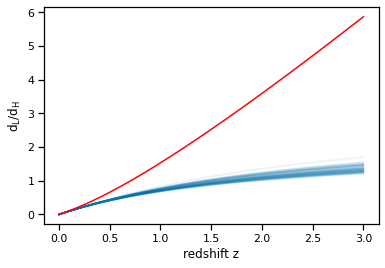

In [15]:
for _ in range(100):
    c = np.random.choice(trace.posterior.chain)
    d = np.random.choice(trace.posterior.draw)
#     print(c, d, trace.posterior.h.sel(chain=c, draw=d))
    d_H = con.c/(100*u.km/u.s)*u.km/u.m/trace.posterior.h.sel(chain=c, draw=d).values
    Om = trace.posterior.Om.sel(chain=c, draw=d).values
    Ode = 1-Om
#     print(d_H, Om)
    Hz = [H(x, Ode, Om) for x in z_range]
    plt.plot(z_range, Hz, color=sns.color_palette()[0], alpha=0.05)
plt.plot(z_range, cosmo.luminosity_distance(z_range)/cosmo.hubble_distance, 'r-')
plt.xlabel("redshift z")
plt.ylabel(r"$\mathrm{d_L/d_H}$")

This is very much not correct, checking to see where it may be wrong is going to need a whole new file or more